In [54]:
!pip install tensorflow =2.5.0

ERROR: Invalid requirement: '=2.5.0'
Hint: = is not a valid operator. Did you mean == ?


In [1]:
from platform import python_version

print(python_version())

3.9.4


^C


In [1]:
import tensorflow as tf

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)
from tensorflow.keras.callbacks import CSVLogger, EarlyStopping

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import time
import gc
import sys

print(f"Tensorflow Version: {tf.__version__}")
print(f"Pandas Version: {pd.__version__}")
print(f"Numpy Version: {np.__version__}")
print(f"System Version: {sys.version}")
print(f"tensorflow-addons: {sys.version}")
print(f"tfa-nightly: {sys.version}")
mpl.rcParams['figure.figsize'] = (17, 5)
mpl.rcParams['axes.grid'] = False
sns.set_style("whitegrid")

notebookstart= time.time()

Tensorflow Version: 2.8.0
Pandas Version: 1.4.0
Numpy Version: 1.22.2
System Version: 3.9.4 (default, Apr  9 2021, 11:43:21) [MSC v.1916 64 bit (AMD64)]
tensorflow-addons: 3.9.4 (default, Apr  9 2021, 11:43:21) [MSC v.1916 64 bit (AMD64)]
tfa-nightly: 3.9.4 (default, Apr  9 2021, 11:43:21) [MSC v.1916 64 bit (AMD64)]


In [2]:
import numpy as np
import pandas as pd
from tensorflow.keras import layers
from tensorflow.keras.optimizers import SGD
from keras.models import Sequential
#from keras.layers import Merge
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.layers.core import Dense, Activation, Dropout, Reshape, Flatten
from keras.utils.np_utils import to_categorical

In [3]:
data = pd.read_csv('df_north.csv')

In [4]:
data = data.fillna(0)
data.index = data['date']
data = data.drop(columns=['date'])

In [5]:
data.head()

,Unnamed: 0,AKSH_227_liq_vol,AKSH_227_wc_vol,AKSH_227_bhp_fluid_level,AKSH_227_bhp_pump_press,AKSH_240_liq_vol,AKSH_240_wc_vol,AKSH_240_bhp_fluid_level,AKSH_240_bhp_pump_press,AKSH_307_liq_vol,...,AKSH_225_water_vol,AKSH_225_water_type,AKSH_220_water_vol,AKSH_220_water_type,AKSH_240_water_vol,AKSH_240_water_type,AKSH_217_water_vol,AKSH_217_water_type,AKSH_299_water_vol,AKSH_299_water_type
date,,,,,,,,,,,,,,,,,,,,,
2017-01-01,0,177.07000,90.021,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,213.0,Артезианская вода,94.0,Артезианская вода,0.0,0,289.0,Артезианская вода,0.0,0
2017-01-02,1,190.92374,90.014,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,202.0,Артезианская вода,94.0,Артезианская вода,0.0,0,287.0,Артезианская вода,0.0,0
2017-01-03,2,168.77000,90.004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,219.0,Артезианская вода,93.0,Артезианская вода,0.0,0,286.0,Артезианская вода,0.0,0
2017-01-04,3,168.17172,89.975,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,205.0,Артезианская вода,94.0,Артезианская вода,0.0,0,287.0,Артезианская вода,0.0,0
2017-01-05,4,168.49000,85.999,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,214.0,Артезианская вода,94.0,Артезианская вода,0.0,0,286.0,Артезианская вода,0.0,0


In [6]:
data = data[(data.index > '2018-01-01')]

In [7]:
watervol = ['AKSH_299_water_vol','AKSH_217_water_vol','AKSH_240_water_vol','AKSH_220_water_vol','AKSH_225_water_vol']

In [8]:
datawc = data[watervol]

In [96]:
features_considered_nort1 = ['AKSH_211_liq_vol','AKSH_344_liq_vol','AKSH_441_liq_vol','AKSH_244_liq_vol','AKSH_228_liq_vol']
target_north = ['AKSH_211_liq_vol','AKSH_344_liq_vol','AKSH_441_liq_vol','AKSH_244_liq_vol','AKSH_228_liq_vol']
features_considered_north2 = ['AKSH_211_bhp_pump_press','AKSH_344_bhp_pump_press','AKSH_441_bhp_pump_press','AKSH_244_bhp_pump_press','AKSH_228_bhp_pump_press']

In [97]:
X_leftl1 = data['AKSH_211_bhp_pump_press']
X_rightl1 = data['AKSH_299_water_vol']

In [98]:
features_considered_north = ['AKSH_211_liq_vol','AKSH_344_liq_vol','AKSH_441_liq_vol','AKSH_244_liq_vol','AKSH_228_liq_vol','AKSH_211_bhp_pump_press','AKSH_344_bhp_pump_press','AKSH_441_bhp_pump_press','AKSH_244_bhp_pump_press','AKSH_228_bhp_pump_press']

In [99]:
#features = data[features_considered]


#features.head()


In [100]:
#features_df = features.loc[(features.index >= '2018-01-01')]
                    

In [101]:
#data['liq_vol'] = data.liq_vol.shift(-15)

In [102]:
#data['AKSH_220'] = data.AKSH_220.shift(-15)

In [122]:
import tensorflow as tf

from tensorflow.keras.callbacks import CSVLogger, EarlyStopping

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import time
import gc
import sys

print(f"Tensorflow Version: {tf.__version__}")
print(f"Pandas Version: {pd.__version__}")
print(f"Numpy Version: {np.__version__}")
print(f"System Version: {sys.version}")

mpl.rcParams['figure.figsize'] = (17, 5)
mpl.rcParams['axes.grid'] = False
sns.set_style("whitegrid")

notebookstart= time.time()

Tensorflow Version: 2.8.0
Pandas Version: 1.4.0
Numpy Version: 1.22.2
System Version: 3.9.4 (default, Apr  9 2021, 11:43:21) [MSC v.1916 64 bit (AMD64)]


In [72]:
import numpy as np
import pandas as pd
from tensorflow.keras import layers
from tensorflow.keras.optimizers import SGD
from keras.models import Sequential
#from keras.layers import Merge
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.layers.core import Dense, Activation, Dropout, Reshape, Flatten
from keras.utils.np_utils import to_categorical

In [73]:
import tensorflow as tf
import numpy
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [74]:
#data = pd.read_excel('oildatadc.xlsx')

In [75]:
#features_considered = ['liq_vol','AKSH_214', 'AKSH_240','AKSH_220','AKSH_241','AKSH_221','AKSH_247','AKSH_217','AKSH_250','AKSH_424','AKSH_225','AKSH_249','AKSH_299']

In [76]:
#features = data[features_considered]

#features.index = data['date']

#dataset = features 

#features.head()

In [77]:
!pip install sklearn

In [78]:
from sklearn.model_selection import train_test_split
#from sklearn.cross_validation import train_test_split

In [79]:
TRAIN_SPLIT = 600

In [80]:
!pip install --upgrade patsy

In [81]:
!pip install statsmodels

In [82]:
from numpy.random import seed
from numpy.random import randn
from statsmodels.graphics.gofplots import qqplot
from matplotlib import pyplot
from scipy import stats
import matplotlib.pyplot as plt

In [83]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential

In [84]:
from tensorflow.keras.layers import BatchNormalization

In [85]:
#watervol = ['AKSH_299_water_vol','AKSH_217_water_vol','AKSH_240_water_vol','AKSH_220_water_vol','AKSH_225_water_vol']

In [86]:
#features2 = ['AKSH_299_water_vol','AKSH_217_water_vol','AKSH_240_water_vol','AKSH_220_water_vol','AKSH_225_water_vol']

In [87]:
#X_left = X_left.shift(-15)

# AKSH_211_liq_vol

In [104]:
X_left = data[features_considered_north2]
X_right = data[watervol]
Y_train = data['AKSH_211_liq_vol']#,'AKSH_226_liq_vol'] 


X_leftl = X_left[(data.index < '2020-01-01')]
X_rightl = X_right[(data.index < '2020-01-01')]
Y_trainl = Y_train[(data.index < '2020-01-01')]#,'AKSH_226_liq_vol'] 


X_leftt = X_left[(data.index > '2020-01-01')]
X_rightt = X_right[(data.index > '2020-01-01')]
Y_traint = Y_train[(data.index > '2020-01-01')]#,'AKSH_226_liq_vol'] 


X_leftl1 = X_leftl1[(data.index < '2020-01-01')]
X_rightl1 = X_rightl1[(data.index < '2020-01-01')]

In [55]:
datadlearn = X_leftl.index 
datadtrain = X_leftt.index 

AttributeError: 'numpy.ndarray' object has no attribute 'index'

In [105]:
X_left = np.asarray(X_left)
X_right = np.asarray(X_right) 
Y_train = np.asarray(Y_train)
X_leftl = np.asarray(X_leftl)
X_rightl = np.asarray(X_rightl) 
Y_trainl = np.asarray(Y_trainl)
X_leftt = np.asarray(X_leftt)
X_rightt = np.asarray(X_rightt) 
Y_traint = np.asarray(Y_traint)

In [106]:
X_leftl1 = np.asarray(X_leftl1) 
X_rightl1 = np.asarray(X_rightl1) 


In [107]:
X_left = data[features_considered_north2]
X_right = data[watervol]
Y_train = data['AKSH_211_liq_vol']#,'AKSH_226_liq_vol'] 
X_right = X_right.shift(-15)
X_left = np.asarray(X_left)
X_right = np.asarray(X_right) 
Y_train = np.asarray(Y_train) 
datadd = data.index 
datadd = datadd.to_numpy()
#Y_train = data['AKSH_211_liq_vol']


In [108]:

X_leftl1.shape

(729,)

In [46]:
#single_step_model.predict(X_left)

# LSTM_LSTM_

In [109]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, TimeDistributed, Conv1D, MaxPooling1D, Flatten, Bidirectional, Input, Flatten, Activation, Reshape, RepeatVector, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [118]:
# multivariate mlp example
from numpy import array
from numpy import hstack
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from keras.layers.merge import concatenate
import tensorflow as tf
import tensorflow_addons as tfa 
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
	X, y = list(), list() # листы
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps_in # подваваемая последовательность
		out_end_ix = end_ix + n_steps_out # рекурсивный вывод
		# проверка на выход за пределы 
		if out_end_ix > len(sequences):
			break
		# совмещение ввода и вывода  (общая последовательность)
		seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, :]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)
 
 
# последовательность
in_seq1 = X_leftl
in_seq2 = X_rightl
out_seq = Y_trainl # array([in_seq1[i]+in_seq2[i] for i in range(len(in_seq1))])
# конвертация в формат колонок и рядов
in_seq1 = in_seq1.reshape((len(in_seq1), 5)) # пять на одну
in_seq2 = in_seq2.reshape((len(in_seq2), 5)) # пять на другую ветвь
out_seq = out_seq.reshape((len(out_seq), 1))
# горизонтальное последовательное размещение данных 
dataset = hstack((in_seq1, in_seq2, out_seq))
# таймстепы
# таймстепы
n_features = 5

n_steps_in, n_steps_out = 15, 1
# convert into input/output
X,y = split_sequences(dataset, n_steps_in, n_steps_out)
n_features1 = 5
n_features2 = 5
# разделение данных 
X1 = X[:, :, :5]
X2 = X[:, :, :5]
# первая модель
visible1 = Input(shape=(n_steps_in,n_features1),batch_size = 1) # формат данных

visible1n = tfa.layers.GroupNormalization(1,-1,0.001,False)(visible1)
dense1 = LSTM(n_steps_in, input_shape =(100,n_features1), stateful = True)(visible1n) # режим stateful для левой

visible11 = (RepeatVector(n_steps_out))(dense1)

visible21 = (LSTM(n_steps_in, activation='softplus',return_sequences=True))(visible11)
visible31 = (TimeDistributed(Dense(n_features1)))(visible21)


#,batch_input_shape=(32,100,1), stateful=True
# вторая модель LSTM
visible2 = Input(shape=(n_steps_in,n_features2))
visible2n = tfa.layers.GroupNormalization(1,-1,0.001,False)(visible2)

lstm = LSTM(n_steps_in, input_shape =(100,n_features2))(visible2n)

visible12 = (RepeatVector(n_steps_out))(lstm)
visible22 = (LSTM(n_steps_in, activation='softplus',return_sequences=True))(visible12)
visible32 = (TimeDistributed(Dense(n_features2)))(visible22)


#lstm2 = LSTM(10, input_shape =(100,1))(lstm)

# слияние
merge = concatenate([dense1, lstm])
output = Dense(1)(merge) # можно другой ПРАВАЯ ВЕТВЬ ОТКЛЮЧЕНА
model = Model(inputs=[visible1,visible2], outputs=output)
model.compile(optimizer='adam', loss='mape', metrics=['accuracy'])
# fit model
model.fit([X1,X2], Y_trainl, epochs=4, verbose=1, batch_size=1, validation_split=0.01)
# demonstrate prediction
#x_input = array([[80, 85], [90, 95], [100, 105]])
#x1 = x_input[:, 0].reshape((1, n_steps))
#x2 = x_input[:, 1].reshape((1, n_steps))
yhat = model.predict([X1,X2], verbose=0, batch_size=1)
print(yhat)

Epoch 1/4


UnknownError: Graph execution error:

Fail to find the dnn implementation.
	 [[{{node CudnnRNN}}]]
	 [[model_8/lstm_35/PartitionedCall]] [Op:__inference_train_function_36181]

In [45]:
lstm 

<KerasTensor: shape=(None, 15) dtype=float32 (created by layer 'lstm_10')>

# ГЕНЕРАТОР ПРОГНОЗА ДЛЯ 5-5 МЕРНЫХ ВХОДОВ

In [ ]:
# multivariate mlp example
from numpy import array
from numpy import hstack
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers.merge import concatenate
 
# разбиение выборки на шаги рекурсии
def split_sequences(sequences, n_steps_in, n_steps_out):
	X, y = list(), list() # объявление пустых списков
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps_in # входные окна истории
		out_end_ix = end_ix + n_steps_out # прогнозируемые шаги
		# check if we are beyond the dataset
		if out_end_ix > len(sequences): # проверка на длину
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, :] 
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)
 
# последовательность
in_seq1 = X_leftt
in_seq2 = X_rightt
out_seq = Y_traint # array([in_seq1[i]+in_seq2[i] for i in range(len(in_seq1))])
# конвертация в формат колонок и рядов
in_seq1 = in_seq1.reshape((len(in_seq1), 5,))
#in_seq2 = in_seq2.reshape((len(in_seq2), 5,))
out_seq = out_seq.reshape((len(out_seq), 1,))
# горизонтальное последовательное размещение данных 
dataset = hstack((in_seq1, out_seq))
# таймстепы
# таймстепы
n_steps_in, n_steps_out = 15, 2 # 15 окно 2 дня прогноз
# convert into input/output
X,y = split_sequences(dataset, n_steps_in, n_steps_out)



# разделение данных 
X1 = X[:, :, :5]
#X2 = X[:, :, :5]
# первая модель

yhat = model.predict([X1],batch_size=1, verbose=0)
print(yhat)

In [50]:
yhat.shape

(119,)

<AxesSubplot:>

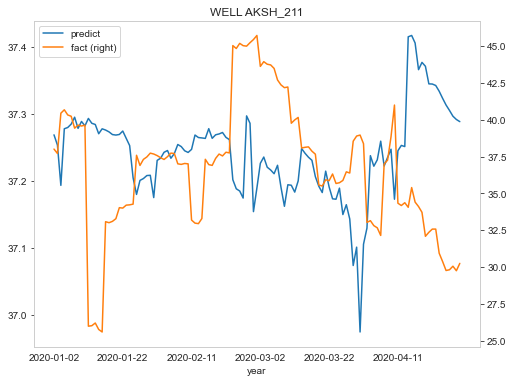

In [51]:
yhat = yhat.flatten() 
Y_traint = Y_traint.flatten()
Y_traint4 = Y_traint[0:119]
datadt4 = datadtrain[0:119]
import pandas as pd

df = pd.DataFrame(data={'year': datadt4, 
                        'predict': yhat, 
                        'fact': Y_traint4})
import matplotlib.pyplot as plt # Impot the relevant module

fig, ax = plt.subplots() # Create the figure and axes object

# Plot the first x and y axes:
df.plot(x = 'year', y = 'predict',title = "WELL AKSH_211", ax = ax) 
# Plot the second x and y axes. By secondary_y = True a second y-axis is requested:
# (see https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.html for details)
df.plot(x = 'year', y = 'fact', ax = ax, secondary_y = True)
#df.plot(label="test1")

In [52]:
from sklearn.metrics import r2_score
r2_score(Y_traint4, yhat)

-0.028617223212342724

In [53]:
from sklearn.metrics import mean_absolute_percentage_error

mean_absolute_percentage_error(Y_traint4, yhat)

0.09795649577620272

In [54]:
from sklearn.metrics import mean_squared_error
mean_squared_error(Y_traint4, yhat, squared=False)

4.504303065929369

In [55]:
from sklearn.metrics import mean_squared_error
mean_squared_error(Y_traint4, yhat, squared=False)

4.504303065929369

In [56]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(Y_traint4, yhat)

3.401838486434808

# РАЗМЕРНОСТЬ 1-1

In [112]:
# multivariate mlp example
from numpy import array
from numpy import hstack
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers.merge import concatenate
 
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the dataset
		if out_end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, :]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)
 
 
# последовательность
in_seq1 = X_leftl1
in_seq2 = X_rightl1
out_seq = Y_trainl # array([in_seq1[i]+in_seq2[i] for i in range(len(in_seq1))])
# конвертация в формат колонок и рядов
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))
# горизонтальное последовательное размещение данных 
dataset = hstack((in_seq1, in_seq2, out_seq))
# таймстепы
# таймстепы
n_steps_in, n_steps_out = 15, 1
# convert into input/output

n_features = 1


X,y = split_sequences(dataset, n_steps_in, n_steps_out)
n_features1 = 1
n_features2 = 1
# разделение данных 
X1 = X[:, :, 1]
X2 = X[:, :, 0]
# первая модель
visible1 = Input(shape=(n_steps_in,n_features1))
regul = tf.keras.layers.ActivityRegularization(l1=0.1, l2=0.1,input_shape=(n_steps_in,n_features1))(visible1)
dense1 = LSTM(100, input_shape =(100,n_features1))(regul)

visible11 = (RepeatVector(n_steps_out))(dense1)
visible21 = (LSTM(n_steps_in, activation='softplus',return_sequences=True))(visible11)
visible31 = (TimeDistributed(Dense(n_features)))(visible21)


#,batch_input_shape=(32,100,1), stateful=True
# вторая модель LSTM
visible2 = Input(shape=(n_steps_in,n_features2))
regul = tf.keras.layers.ActivityRegularization(l1=0.1, l2=0.1,input_shape=(n_steps_in,n_features1))(visible2)
lstm = LSTM(100, input_shape =(100,n_features2))(regul)

visible12 = (RepeatVector(n_steps_out))(lstm)
visible22 = (LSTM(200, activation='softplus',return_sequences=True))(visible12)
visible32 = (TimeDistributed(Dense(n_features)))(visible22)


#lstm2 = LSTM(10, input_shape =(100,1))(lstm)

# слияние
merge = concatenate([dense1, lstm])
output = Dense(1)(merge)
model = Model(inputs=[visible1, visible2], outputs=output)
model.compile(optimizer='adam', loss='mape', metrics=['accuracy'])
# fit model
model.fit([X1, X2], Y_trainl, epochs=10, verbose=1, batch_size=64, validation_split=0.01)
# demonstrate prediction
#x_input = array([[80, 85], [90, 95], [100, 105]])
#x1 = x_input[:, 0].reshape((1, n_steps))
#x2 = x_input[:, 1].reshape((1, n_steps))
yhat = model.predict([X1, X2], verbose=0)
print(yhat)



Epoch 1/10


UnknownError: Graph execution error:

Fail to find the dnn implementation.
	 [[{{node CudnnRNN}}]]
	 [[model_5/lstm_23/PartitionedCall]] [Op:__inference_train_function_21007]

In [116]:
# multivariate mlp example
from numpy import array
from numpy import hstack
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers.merge import concatenate
 
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the dataset
		if out_end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, :]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)
 
 
# последовательность
in_seq1 = X_leftl1
#in_seq2 = X_rightl1
out_seq = Y_trainl # array([in_seq1[i]+in_seq2[i] for i in range(len(in_seq1))])
# конвертация в формат колонок и рядов
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
#in_seq2 = in_seq2.reshape((len(in_seq2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))
# горизонтальное последовательное размещение данных 
dataset = hstack((in_seq1,out_seq))
# таймстепы
# таймстепы
n_steps_in, n_steps_out = 15, 1
# convert into input/output

n_features = 1


X,y = split_sequences(dataset, n_steps_in, n_steps_out)
n_features1 = 1
n_features2 = 1
# разделение данных 
X1 = X[:, :, 0]
X2 = X[:, :, 1]
# первая модель
visible1 = Input(shape=(n_steps_in,n_features1))
regul = tf.keras.layers.ActivityRegularization(l1=0.6, l2=0.4,input_shape=(n_steps_in,n_features1))(visible1)
dense1 = LSTM(100, input_shape =(100,n_features1))(regul)

visible11 = (RepeatVector(n_steps_out))(dense1)
visible21 = (LSTM(n_steps_in, activation='softplus',return_sequences=True))(visible11)
visible31 = (TimeDistributed(Dense(n_features)))(visible21)


#,batch_input_shape=(32,100,1), stateful=True
# вторая модель LSTM


#lstm2 = LSTM(10, input_shape =(100,1))(lstm)

# слияние
#merge = concatenate([dense1])
output = Dense(1)(visible31)
model = Model(inputs=[visible1], outputs=output)
model.compile(optimizer='adam', loss='mape', metrics=['accuracy'])
# fit model
model.fit([X1], Y_trainl, epochs=10, verbose=1, batch_size=64, validation_split=0.01)
# demonstrate prediction
#x_input = array([[80, 85], [90, 95], [100, 105]])
#x1 = x_input[:, 0].reshape((1, n_steps))
#x2 = x_input[:, 1].reshape((1, n_steps))
yhat = model.predict([X1], verbose=0)
print(yhat)



Epoch 1/10


UnknownError: Graph execution error:

Fail to find the dnn implementation.
	 [[{{node CudnnRNN}}]]
	 [[model_7/lstm_31/PartitionedCall]] [Op:__inference_train_function_30757]

In [ ]:
# multivariate mlp example
from numpy import array
from numpy import hstack
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers.merge import concatenate
 
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the dataset
		if out_end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, :]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)
 
 
# последовательность
in_seq1 = X_leftt
#in_seq2 = X_rightt
out_seq = Y_traint # array([in_seq1[i]+in_seq2[i] for i in range(len(in_seq1))])
# конвертация в формат колонок и рядов
in_seq1 = in_seq1.reshape((len(in_seq1), 5))
#in_seq2 = in_seq2.reshape((len(in_seq2), 5))
out_seq = out_seq.reshape((len(out_seq), 1))
# горизонтальное последовательное размещение данных 
dataset = hstack((in_seq1,out_seq))
# таймстепы
# таймстепы
n_steps_in, n_steps_out = 15, 1
# convert into input/output
X,y = split_sequences(dataset, n_steps_in, n_steps_out)



# разделение данных 
X1 = X[:, :, 0]
#2 = X[:, :, 1]
# первая модель

yhat = model.predict([X1], verbose=1)
print(yhat)

In [ ]:
yhat.shape

In [ ]:
yhat = yhat.flatten() 
Y_traint = Y_traint.flatten()
Y_traint4 = Y_traint[0:120]
datadt4 = datadtrain[0:120]
import pandas as pd

df = pd.DataFrame(data={'year': datadt4, 
                        'predict': yhat, 
                        'fact': Y_traint4})
import matplotlib.pyplot as plt # Impot the relevant module

fig, ax = plt.subplots() # Create the figure and axes object

# Plot the first x and y axes:
df.plot(x = 'year', y = 'predict',title = "WELL AKSH_211", ax = ax) 
# Plot the second x and y axes. By secondary_y = True a second y-axis is requested:
# (see https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.html for details)
df.plot(x = 'year', y = 'fact', ax = ax, secondary_y = True)
#df.plot(label="test1")

In [ ]:
from sklearn.metrics import r2_score
r2_score(Y_traint4, yhat)

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error

mean_absolute_percentage_error(Y_traint4, yhat)

In [ ]:
from sklearn.metrics import mean_squared_error
mean_squared_error(Y_traint4, yhat, squared=False)

In [ ]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(Y_traint4, yhat)

In [ ]:
# multivariate mlp example
from numpy import array
from numpy import hstack
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers.merge import concatenate
 
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the dataset
		if out_end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, :]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)
 
 
# последовательность
in_seq1 = X_leftt
in_seq2 = X_rightt
out_seq = Y_traint # array([in_seq1[i]+in_seq2[i] for i in range(len(in_seq1))])
# конвертация в формат колонок и рядов
in_seq1 = in_seq1.reshape((len(in_seq1), 5,1,1))
in_seq2 = in_seq2.reshape((len(in_seq2), 5,1,1))
out_seq = out_seq.reshape((len(out_seq), 1,1,1))
# горизонтальное последовательное размещение данных 
dataset = hstack((in_seq1, in_seq2, out_seq))
# таймстепы
# таймстепы
n_steps_in, n_steps_out = 15, 1
# convert into input/output
X,y = split_sequences(dataset, n_steps_in, n_steps_out)



# разделение данных 
X1 = X[:, :, 0]
X2 = X[:, :, 1]
# первая модель

yhat = model.predict([X1, X2],batch_size=1, verbose=0)
print(yhat)

In [ ]:
yhat.shape


In [ ]:
yhat = yhat.flatten()
yhat = yhat[0:120]
Y_traint = Y_traint.flatten()
Y_traint4 = Y_traint[0:120]
datadt4 = datadtrain[0:120]

#datadt4 = datadt[0:120]
import pandas as pd

df = pd.DataFrame(data={'year': datadt4, 
                        'predict': yhat, 
                        'fact': Y_traint4})
import matplotlib.pyplot as plt # Impot the relevant module

fig, ax = plt.subplots() # Create the figure and axes object

# Plot the first x and y axes:
df.plot(x = 'year', y = 'predict',title = "WELL AKSH_211", ax = ax) 
# Plot the second x and y axes. By secondary_y = True a second y-axis is requested:
# (see https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.html for details)
df.plot(x = 'year', y = 'fact', ax = ax, secondary_y = True)
#df.plot(label="test1")

In [ ]:
#from sklearn.metrics import mean_squared_error
#mean_squared_error(yhat, datadt4, False)

# ENCODER_DECODER_LSTM_LSTM(REPEATER)

In [ ]:
# multivariate mlp example
from numpy import array
from numpy import hstack
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers.merge import concatenate
import tensorflow as tf
import tensorflow_addons as tfa 
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the dataset
		if out_end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, :]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)
 
 
# последовательность
in_seq1 = X_leftl
in_seq2 = X_rightl
out_seq = Y_trainl # array([in_seq1[i]+in_seq2[i] for i in range(len(in_seq1))])
# конвертация в формат колонок и рядов
in_seq1 = in_seq1.reshape((len(in_seq1), 5))
in_seq2 = in_seq2.reshape((len(in_seq2), 5))
out_seq = out_seq.reshape((len(out_seq), 1))
# горизонтальное последовательное размещение данных 
dataset = hstack((in_seq1, in_seq2, out_seq))
# таймстепы
# таймстепы
n_features = 1

n_steps_in, n_steps_out = 15, 1
# convert into input/output
X,y = split_sequences(dataset, n_steps_in, n_steps_out)
n_features1 = 5
n_features2 = 5
# разделение данных 
X1 = X[:, :, :5]
X2 = X[:, :, :5]
# первая модель
visible1 = Input(shape=(n_steps_in,n_features1))

visible1n = tfa.layers.GroupNormalization(1,-1,0.001,False)(visible1)
dense1 = LSTM(n_steps_in, input_shape =(100,n_features1))(visible1n)

visible11 = (RepeatVector(n_steps_out))(dense1)

visible21 = (LSTM(n_steps_in, activation='softplus',return_sequences=True))(visible11)
visible31 = (TimeDistributed(Dense(n_features)))(visible21)


#,batch_input_shape=(32,100,1), stateful=True
# вторая модель LSTM
visible2 = Input(shape=(n_steps_in,n_features2))
visible2n = tfa.layers.GroupNormalization(1,-1,0.001,False)(visible2)

lstm = LSTM(n_steps_in, input_shape =(100,n_features2))(visible2n)

visible12 = (RepeatVector(n_steps_out))(lstm)
visible22 = (LSTM(n_steps_in, activation='softplus',return_sequences=True))(visible12)
visible32 = (TimeDistributed(Dense(n_features)))(visible22)


#lstm2 = LSTM(10, input_shape =(100,1))(lstm)

# слияние
merge = concatenate([dense1, lstm])
output = Dense(1)(merge)
model = Model(inputs=[visible1, visible2], outputs=output)
model.compile(optimizer='adam', loss='mape', metrics=['accuracy'])
# fit model
model.fit([X1, X2], Y_trainl, epochs=4, verbose=1, batch_size=16, validation_split=0.01)
# demonstrate prediction
#x_input = array([[80, 85], [90, 95], [100, 105]])
#x1 = x_input[:, 0].reshape((1, n_steps))
#x2 = x_input[:, 1].reshape((1, n_steps))
yhat = model.predict([X1, X2], verbose=0)
print(yhat)

In [ ]:
visible1.shape

In [ ]:
# multivariate mlp example
from numpy import array
from numpy import hstack
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers.merge import concatenate
 
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the dataset
		if out_end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, :]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)
 
 
# последовательность
in_seq1 = X_leftt
in_seq2 = X_rightt
out_seq = Y_traint # array([in_seq1[i]+in_seq2[i] for i in range(len(in_seq1))])
# конвертация в формат колонок и рядов
in_seq1 = in_seq1.reshape((len(in_seq1),5))
in_seq2 = in_seq2.reshape((len(in_seq2),5))
out_seq = out_seq.reshape((len(out_seq),1))
# горизонтальное последовательное размещение данных 
dataset = hstack((in_seq1, in_seq2, out_seq))
# таймстепы
# таймстепы
n_steps_in, n_steps_out = 15, 1
# convert into input/output
X,y = split_sequences(dataset, n_steps_in, n_steps_out)



# разделение данных 
X1 = X[:, :, :5]
X2 = X[:, :, :5]
# первая модель

yhat = model.predict([X1, X2],batch_size=1, verbose=0)
print(yhat)

# LSTM_LSTM_Group_Normalization

In [ ]:
# multivariate mlp example
from numpy import array
from numpy import hstack
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers.merge import concatenate
import tensorflow as tf
import tensorflow_addons as tfa 
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the dataset
		if out_end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, :]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)
 
 
# последовательность
in_seq1 = X_leftl
in_seq2 = X_rightl
out_seq = Y_trainl # array([in_seq1[i]+in_seq2[i] for i in range(len(in_seq1))])
# конвертация в формат колонок и рядов
in_seq1 = in_seq1.reshape((len(in_seq1), 5))
in_seq2 = in_seq2.reshape((len(in_seq2), 5))
out_seq = out_seq.reshape((len(out_seq), 1))
# горизонтальное последовательное размещение данных 
dataset = hstack((in_seq1, in_seq2, out_seq))
# таймстепы
# таймстепы
n_features = 1

n_steps_in, n_steps_out = 15, 1
# convert into input/output
X,y = split_sequences(dataset, n_steps_in, n_steps_out)
n_features1 = 1
n_features2 = 1
# разделение данных 
X1 = X[:, :, 0]
X2 = X[:, :, 1]
# первая модель
visible1 = Input(shape=(n_steps_in,n_features1))

visible1n = tfa.layers.GroupNormalization(1,-1,0.001,False)(visible1)
dense1 = LSTM(n_steps_in, input_shape =(100,n_features1))(visible1n)

visible11 = (RepeatVector(n_steps_out))(dense1)

visible21 = (LSTM(n_steps_in, activation='softplus',return_sequences=True))(visible11)
visible31 = (TimeDistributed(Dense(n_features)))(visible21)


#,batch_input_shape=(32,100,1), stateful=True
# вторая модель LSTM
visible2 = Input(shape=(n_steps_in,n_features2))
visible2n = tfa.layers.GroupNormalization(1,-1,0.001,False)(visible2)

lstm = LSTM(n_steps_in, input_shape =(100,n_features2))(visible2n)

visible12 = (RepeatVector(n_steps_out))(lstm)
visible22 = (LSTM(n_steps_in, activation='softplus',return_sequences=True))(visible12)
visible32 = (TimeDistributed(Dense(n_features)))(visible22)


#lstm2 = LSTM(10, input_shape =(100,1))(lstm)

# слияние
merge = concatenate([dense1, lstm])
output = Dense(1)(merge)
model = Model(inputs=[visible1, visible2], outputs=output)
model.compile(optimizer='adam', loss='mape', metrics=['accuracy'])
# fit model
model.fit([X1, X2], Y_trainl, epochs=400, verbose=1, batch_size=16, validation_split=0.01)
# demonstrate prediction
#x_input = array([[80, 85], [90, 95], [100, 105]])
#x1 = x_input[:, 0].reshape((1, n_steps))
#x2 = x_input[:, 1].reshape((1, n_steps))
yhat = model.predict([X1, X2], verbose=0)
print(yhat)

In [ ]:
# multivariate mlp example
from numpy import array
from numpy import hstack
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers.merge import concatenate
 
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the dataset
		if out_end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, :]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)
 
 
# последовательность
in_seq1 = X_leftt
in_seq2 = X_rightt
out_seq = Y_traint # array([in_seq1[i]+in_seq2[i] for i in range(len(in_seq1))])
# конвертация в формат колонок и рядов
in_seq1 = in_seq1.reshape((len(in_seq1), 5,1,1))
in_seq2 = in_seq2.reshape((len(in_seq2), 5,1,1))
out_seq = out_seq.reshape((len(out_seq), 1,1,1))
# горизонтальное последовательное размещение данных 
dataset = hstack((in_seq1, in_seq2, out_seq))
# таймстепы
# таймстепы
n_steps_in, n_steps_out = 15, 1
# convert into input/output
X,y = split_sequences(dataset, n_steps_in, n_steps_out)



# разделение данных 
X1 = X[:, :, 0]
X2 = X[:, :, 1]
# первая модель

yhat = model.predict([X1, X2],batch_size=1, verbose=0)
print(yhat)

In [ ]:
# multivariate mlp example
from numpy import array
from numpy import hstack
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers.merge import concatenate
import tensorflow as tf
import tensorflow_addons as tfa 
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the dataset
		if out_end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, :]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)
 
 
# последовательность
in_seq1 = X_leftl
in_seq2 = X_rightl
out_seq = Y_trainl # array([in_seq1[i]+in_seq2[i] for i in range(len(in_seq1))])
# конвертация в формат колонок и рядов
in_seq1 = in_seq1.reshape((len(in_seq1), 5))
in_seq2 = in_seq2.reshape((len(in_seq2), 5))
out_seq = out_seq.reshape((len(out_seq), 1))
# горизонтальное последовательное размещение данных 
dataset = hstack((in_seq1, in_seq2, out_seq))
# таймстепы
# таймстепы
n_features = 1

n_steps_in, n_steps_out = 15, 1
# convert into input/output
X,y = split_sequences(dataset, n_steps_in, n_steps_out)
n_features1 = 5
n_features2 = 5
# разделение данных 
X1 = X[:, :, :5]
X2 = X[:, :, :5]
# первая модель
visible1 = Input(shape=(n_steps_in,n_features1))

visible1n = tfa.layers.GroupNormalization(1,-1,0.001,False)(visible1)
dense1 = LSTM(n_steps_in, input_shape =(100,n_features1))(visible1n)

visible11 = (RepeatVector(n_steps_out))(dense1)

visible21 = (LSTM(n_steps_in, activation='softplus',return_sequences=True))(visible11)
visible31 = (TimeDistributed(Dense(n_features)))(visible21)


#,batch_input_shape=(32,100,1), stateful=True
# вторая модель LSTM
visible2 = Input(shape=(n_steps_in,n_features2))
visible2n = tfa.layers.GroupNormalization(1,-1,0.001,False)(visible2)

lstm = LSTM(n_steps_in, input_shape =(100,n_features2))(visible2n)

visible12 = (RepeatVector(n_steps_out))(lstm)
visible22 = (LSTM(n_steps_in, activation='softplus',return_sequences=True))(visible12)
visible32 = (TimeDistributed(Dense(n_features)))(visible22)


#lstm2 = LSTM(10, input_shape =(100,1))(lstm)

# слияние
merge = concatenate([dense1, lstm])
output = Dense(1)(merge)
model = Model(inputs=[visible1, visible2], outputs=output)
model.compile(optimizer='adam', loss='mape', metrics=['accuracy'])
# fit model
model.fit([X1, X2], Y_trainl, epochs=400, verbose=1, batch_size=16, validation_split=0.01)
# demonstrate prediction
#x_input = array([[80, 85], [90, 95], [100, 105]])
#x1 = x_input[:, 0].reshape((1, n_steps))
#x2 = x_input[:, 1].reshape((1, n_steps))
yhat = model.predict([X1, X2], verbose=0)
print(yhat)

In [ ]:
yhat = yhat.flatten()
yhat = yhat[0:120]
Y_traint = Y_traint.flatten()
Y_traint4 = Y_traint[0:120]
datadt4 = datadtrain[0:120]

#datadt4 = datadt[0:120]
import pandas as pd

df = pd.DataFrame(data={'year': datadt4, 
                        'predict': yhat, 
                        'fact': Y_traint4})
import matplotlib.pyplot as plt # Impot the relevant module

fig, ax = plt.subplots() # Create the figure and axes object

# Plot the first x and y axes:
df.plot(x = 'year', y = 'predict',title = "WELL AKSH_211", ax = ax) 
# Plot the second x and y axes. By secondary_y = True a second y-axis is requested:
# (see https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.html for details)
df.plot(x = 'year', y = 'fact', ax = ax, secondary_y = True)
#df.plot(label="test1")

In [ ]:
from sklearn.metrics import mean_squared_error     
    
mean_squared_error(Y_traint4, yhat)

In [ ]:
from sklearn.metrics import r2_score
r2_score(Y_traint4, yhat)

In [ ]:
from sklearn.metrics import mean_squared_error
mean_squared_error(Y_traint4, yhat, squared=False)

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error

mean_absolute_percentage_error(Y_traint4, yhat)

In [ ]:
from sklearn.metrics import mean_absolute_error
mean_squared_error(Y_traint4, yhat)

# ЯДРА

# TEST_PREDICTION(любое ядро кроме ConvLSTM2D)

In [ ]:
yhat.shape

In [ ]:
yhat = yhat.flatten() 
Y_traint = Y_traint.flatten()
Y_traint4 = Y_traint[0:120]
datadt4 = datadtrain[0:120]
import pandas as pd

df = pd.DataFrame(data={'year': datadt4, 
                        'predict': yhat, 
                        'fact': Y_traint4})
import matplotlib.pyplot as plt # Impot the relevant module

fig, ax = plt.subplots() # Create the figure and axes object

# Plot the first x and y axes:
df.plot(x = 'year', y = 'predict',title = "WELL AKSH_211", ax = ax) 
# Plot the second x and y axes. By secondary_y = True a second y-axis is requested:
# (see https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.html for details)
df.plot(x = 'year', y = 'fact', ax = ax, secondary_y = True)
#df.plot(label="test1")

In [ ]:
from sklearn.metrics import r2_score
r2_score(Y_traint4, yhat)

# LSTM_LSTM_Group_Normalization_Time_Distributed (корректная модель)

In [ ]:
# multivariate mlp example
from numpy import array
from numpy import hstack
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers.merge import concatenate
import tensorflow as tf
import tensorflow_addons as tfa 
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the dataset
		if out_end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, :]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)
 
 
# последовательность
in_seq1 = X_leftl
in_seq2 = X_rightl
out_seq = Y_trainl # array([in_seq1[i]+in_seq2[i] for i in range(len(in_seq1))])
# конвертация в формат колонок и рядов
in_seq1 = in_seq1.reshape((len(in_seq1), 5))
in_seq2 = in_seq2.reshape((len(in_seq2), 5))
out_seq = out_seq.reshape((len(out_seq), 1))
# горизонтальное последовательное размещение данных 
dataset = hstack((in_seq1, in_seq2, out_seq))
# таймстепы
# таймстепы
n_features = 1

n_steps_in, n_steps_out = 15, 2
# convert into input/output
X,y = split_sequences(dataset, n_steps_in, n_steps_out)
n_features1 = 5
n_features2 = 5
# разделение данных 
X1 = X[:, :, :5]
X2 = X[:, :, :5]
# первая модель
visible1 = Input(shape=(n_steps_in,n_features1))

visible1n = tfa.layers.GroupNormalization(1,-1,0.001,False)(visible1)
dense1 = LSTM(n_steps_in, input_shape =(100,n_features1))(visible1n)

visible11 = (RepeatVector(n_steps_out))(dense1)

visible21 = (LSTM(n_steps_in, activation='softplus',return_sequences=True))(visible11)
visible31 = (TimeDistributed(Dense(n_features1)))(visible21)


#,batch_input_shape=(32,100,1), stateful=True
# вторая модель LSTM
visible2 = Input(shape=(n_steps_in,n_features2))
visible2n = tfa.layers.GroupNormalization(1,-1,0.001,False)(visible2)

lstm = LSTM(n_steps_in, input_shape =(100,n_features2))(visible2n)

visible12 = (RepeatVector(n_steps_out))(lstm)
visible22 = (LSTM(n_steps_in, activation='softplus',return_sequences=True))(visible12)
visible32 = (TimeDistributed(Dense(n_features2)))(visible22)


#lstm2 = LSTM(10, input_shape =(100,1))(lstm)

# слияние
merge = concatenate([dense1, lstm])
output = Dense(1)(merge)
model = Model(inputs=[visible1, visible2], outputs=output)
model.compile(optimizer='adam', loss='mape', metrics=['accuracy'])
# fit model
model.fit([X1, X2], Y_trainl, epochs=400, verbose=1, batch_size=16, validation_split=0.01)
# demonstrate prediction
#x_input = array([[80, 85], [90, 95], [100, 105]])
#x1 = x_input[:, 0].reshape((1, n_steps))
#x2 = x_input[:, 1].reshape((1, n_steps))
yhat = model.predict([X1, X2], verbose=0)
print(yhat)

In [ ]:
# multivariate mlp example
from numpy import array
from numpy import hstack
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers.merge import concatenate
import tensorflow as tf
import tensorflow_addons as tfa 
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the dataset
		if out_end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, :]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)
 
 
# последовательность
in_seq1 = X_leftl1
in_seq2 = X_rightl1
out_seq = Y_trainl # array([in_seq1[i]+in_seq2[i] for i in range(len(in_seq1))])
# конвертация в формат колонок и рядов
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))
# горизонтальное последовательное размещение данных 
dataset = hstack((in_seq1, in_seq2, out_seq))
# таймстепы
# таймстепы
n_steps_in, n_steps_out = 15, 1
# convert into input/output
X,y = split_sequences(dataset, n_steps_in, n_steps_out)
n_features1 = 1
n_features2 = 1
# разделение данных 
X1 = X[:, :, 0]
X2 = X[:, :, 1]
# первая модель
visible1 = Input(shape=(n_steps_in,n_features1))

visible1n = tfa.layers.GroupNormalization(1,-1,0.001,False)(visible1)
dense1 = LSTM(100, input_shape =(100,n_features1))(visible1n)

visible11 = (RepeatVector(n_steps_out))(dense1)

visible21 = (LSTM(n_steps, activation='softplus',return_sequences=True))(visible11)
visible31 = (TimeDistributed(Dense(n_features)))(visible21)


#,batch_input_shape=(32,100,1), stateful=True
# вторая модель LSTM
visible2 = Input(shape=(n_steps_in,n_features2))
visible2n = tfa.layers.GroupNormalization(1,-1,0.001,False)(visible2)

lstm = LSTM(100, input_shape =(100,n_features2))(visible2n)

visible12 = (RepeatVector(n_steps_out))(lstm)
visible22 = (LSTM(200, activation='softplus',return_sequences=True))(visible12)
visible32 = (TimeDistributed(Dense(n_features)))(visible22)


#lstm2 = LSTM(10, input_shape =(100,1))(lstm)

# слияние
merge = concatenate([dense1, lstm])
output = Dense(1)(merge)
model = Model(inputs=[visible1, visible2], outputs=output)
model.compile(optimizer='adam', loss='mape', metrics=['accuracy'])
# fit model
model.fit([X1, X2], Y_trainl, epochs=400, verbose=1, batch_size=16, validation_split=0.01)
# demonstrate prediction
#x_input = array([[80, 85], [90, 95], [100, 105]])
#x1 = x_input[:, 0].reshape((1, n_steps))
#x2 = x_input[:, 1].reshape((1, n_steps))
yhat = model.predict([X1, X2], verbose=0)
print(yhat)

In [ ]:
# multivariate mlp example
from numpy import array
from numpy import hstack
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers.merge import concatenate
 
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the dataset
		if out_end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, :]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)
 
 
# последовательность
in_seq1 = X_leftt
in_seq2 = X_rightt
out_seq = Y_traint # array([in_seq1[i]+in_seq2[i] for i in range(len(in_seq1))])
# конвертация в формат колонок и рядов
in_seq1 = in_seq1.reshape((len(in_seq1), 5))
in_seq2 = in_seq2.reshape((len(in_seq2), 5))
out_seq = out_seq.reshape((len(out_seq), 1))
# горизонтальное последовательное размещение данных 
dataset = hstack((in_seq1, in_seq2, out_seq))
# таймстепы
# таймстепы
n_steps_in, n_steps_out = 15, 1
# convert into input/output
X,y = split_sequences(dataset, n_steps_in, n_steps_out)



# разделение данных 
X1 = X[:, :, :5]
X2 = X[:, :, :5]
# первая модель

yhat = model.predict([X1, X2], verbose=0)
print(yhat)

In [ ]:
yhat.shape

In [ ]:
yhat = yhat.flatten() 
Y_traint = Y_traint.flatten()
Y_traint4 = Y_traint[0:120]
datadt4 = datadtrain[0:120]
import pandas as pd

df = pd.DataFrame(data={'year': datadt4, 
                        'predict': yhat, 
                        'fact': Y_traint4})
import matplotlib.pyplot as plt # Impot the relevant module

fig, ax = plt.subplots() # Create the figure and axes object

# Plot the first x and y axes:
df.plot(x = 'year', y = 'predict',title = "WELL AKSH_211", ax = ax) 
# Plot the second x and y axes. By secondary_y = True a second y-axis is requested:
# (see https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.html for details)
df.plot(x = 'year', y = 'fact', ax = ax, secondary_y = True)
#df.plot(label="test1")

# ConvLSTM2D corrected model

# Stateful =True

# Генерация предиктов (входные и прогноз как у модели ConvLSTM2D/!)

In [ ]:
# multivariate mlp example
from numpy import array
from numpy import hstack
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers.merge import concatenate
# multivariate multi-step encoder-decoder lstm example
from numpy import array
from numpy import hstack
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
n_features = 1 
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the dataset
		if out_end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, :]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)
 
# последовательность
in_seq1 = X_leftt#[0:856]
in_seq2 = X_rightt#[0:856]
out_seq = Y_traint#[0:856] # array([in_seq1[i]+in_seq2[i] for i in range(len(in_seq1))])
# конвертация в формат колонок и рядов
in_seq1 = in_seq1.reshape((len(in_seq1),6,1,1))
in_seq2 = in_seq2.reshape((len(in_seq2),5,1,1))
out_seq = out_seq.reshape((len(out_seq),1,1,1))
# горизонтальное последовательное размещение данных 
dataset = hstack((in_seq1, in_seq2, out_seq))
# таймстепы
n_steps_in, n_steps_out = 15, 1

# convert into input/output
X, y = split_sequences(dataset, n_steps_in, n_steps_out)
# разделение данных 
X1 = X[:, :, 0]
X2 = X[:, :, 1]
# первая модель
model.fit([X1, X2], Y_traint, epochs=20, verbose=1, batch_size=100, validation_split=0.1)
# demonstrate prediction
#x_input = array([[80, 85], [90, 95], [100, 105]])
#x1 = x_input[:, 0].reshape((1, n_steps))
#x2 = x_input[:, 1].reshape((1, n_steps))
yhat = model.predict([X1, X2], verbose=0)
print(yhat)

In [ ]:
X.shape

# MLP_MLP_Multistep модель

# ConvLSTM2D corrected model

# MULTISTEP PREDICT ДЛЯ ConvLSTM2D!

In [ ]:
# multivariate mlp example
from numpy import array
from numpy import hstack
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers.merge import concatenate
# multivariate multi-step encoder-decoder lstm example
from numpy import array
from numpy import hstack
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
n_features = 1 
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the dataset
		if out_end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, :]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)
 
# последовательность
in_seq1 = X_leftt#[0:856]
in_seq2 = X_rightt#[0:856]
out_seq = Y_traint#[0:856] # array([in_seq1[i]+in_seq2[i] for i in range(len(in_seq1))])
# конвертация в формат колонок и рядов
in_seq1 = in_seq1.reshape((len(in_seq1),5,1,1))
in_seq2 = in_seq2.reshape((len(in_seq2),5,1,1))
out_seq = out_seq.reshape((len(out_seq),1,1,1))
# горизонтальное последовательное размещение данных 
dataset = hstack((in_seq1, in_seq2, out_seq))
# таймстепы
n_steps_in, n_steps_out = 10, 1

# convert into input/output
X, y = split_sequences(dataset, n_steps_in, n_steps_out)
# разделение данных 
X1 = X[:, :, 0]
X2 = X[:, :, 1]
# первая модель
model.fit([X1, X2], Y_traint, epochs=20, verbose=1, batch_size=100, validation_split=0.1)
# demonstrate prediction
#x_input = array([[80, 85], [90, 95], [100, 105]])
#x1 = x_input[:, 0].reshape((1, n_steps))
#x2 = x_input[:, 1].reshape((1, n_steps))
yhat = model.predict([X1, X2], verbose=0)
print(yhat)

In [ ]:
import pandas as pd

df = pd.DataFrame(data={'year': datadd, 
                        'predict': yhat, 
                        'fact': Y_train})

# AKSH_211

In [1114]:
X_left = data[features_considered_north2]
X_right = data[watervol]
Y_train = data['AKSH_211_liq_vol']#,'AKSH_226_liq_vol'] 


X_leftl = X_left[(data.index < '2020-01-01')]
X_rightl = X_right[(data.index < '2020-01-01')]
Y_trainl = Y_train[(data.index < '2020-01-01')]#,'AKSH_226_liq_vol'] 


X_leftt = X_left[(data.index > '2020-01-01')]
X_rightt = X_right[(data.index > '2020-01-01')]
Y_traint = Y_train[(data.index > '2020-01-01')]#,'AKSH_226_liq_vol'] 

datadd = data.index
datadt = datadd[(data.index > '2020-01-01')]

In [670]:
X_leftl 

,AKSH_211_bhp_pump_press,AKSH_344_bhp_pump_press,AKSH_441_bhp_pump_press,AKSH_244_bhp_pump_press,AKSH_228_bhp_pump_press
date,,,,,
2017-01-01,0.000,0.000,0.000,0.00,0.000
2017-01-02,0.000,0.000,0.000,0.00,0.000
2017-01-03,0.000,0.000,0.000,0.00,0.000
2017-01-04,0.000,0.000,0.000,0.00,0.000
2017-01-05,0.000,0.000,0.000,0.00,0.000
...,...,...,...,...,...
2019-12-27,26.533,36.297,31.844,52.84,64.404
2019-12-28,25.533,36.297,31.844,53.00,64.404
2019-12-29,25.533,35.297,31.844,54.00,64.404


In [1115]:
X_left = np.asarray(X_left)
X_right = np.asarray(X_right) 
Y_train = np.asarray(Y_train)
X_leftl = np.asarray(X_leftl)
X_rightl = np.asarray(X_rightl) 
Y_trainl = np.asarray(Y_trainl)
X_leftt = np.asarray(X_leftt)
X_rightt = np.asarray(X_rightt) 
Y_traint = np.asarray(Y_traint)

In [552]:
yhatt = yhatt.flatten() 
Y_traint = Y_traint.flatten()

In [553]:
yhatt.shape




(1081,)

In [478]:
yhatt.shape

(1217,)

In [502]:
import pandas as pd

df = pd.DataFrame(data={'year': datadt, 
                        'predict': yhatt, 
                        'fact': Y_traint})

In [674]:
# multivariate mlp example
from numpy import array
from numpy import hstack
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers.merge import concatenate
 
# сэмлы
def split_sequences(sequences, n_steps):
	X, y = list(), list()
	for i in range(len(sequences)):
		# разметка
		end_ix = i + n_steps
		# проверка выхода за пределы
		if end_ix > len(sequences):
			break
		# получение начала и конечной метки
		seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)
 
# последовательность
in_seq1 = X_leftt
in_seq2 = X_rightt

out_seq = Y_traint #array([in_seq1[i]+in_seq2[i] for i in range(len(in_seq1))])
# конвертация в формат колонок и рядов
in_seq1 = in_seq1.reshape((len(in_seq1), 5))
in_seq2 = in_seq2.reshape((len(in_seq2), 5))
out_seq = out_seq.reshape((len(out_seq), 1))
# горизонтальное последовательное размещение данных 
dataset = hstack((in_seq1, in_seq2, out_seq))
# таймстепы
n_steps = 15
# convert into input/output
X,y = split_sequences(dataset, n_steps)
#y = 
# разделение данных 
X1 = X[:, :, 0]
X2 = X[:, :, 1]

yhatt = model.predict([X1, X2], verbose=0)
print(yhatt)

[[37.143497]
 [37.079445]
 [37.517982]
 [37.24287 ]
 [37.895935]
 [37.66397 ]
 [37.710598]
 [38.13866 ]
 [38.569077]
 [38.06173 ]
 [38.2402  ]
 [37.940655]
 [37.578724]
 [37.547863]
 [37.41484 ]
 [37.595833]
 [37.02039 ]
 [37.34222 ]
 [36.690517]
 [37.239815]
 [36.33244 ]
 [37.067287]
 [36.830307]
 [36.944412]
 [37.162766]
 [36.71179 ]
 [36.60621 ]
 [36.43983 ]
 [36.4055  ]
 [36.54775 ]
 [36.638157]
 [36.002483]
 [36.027576]
 [36.15391 ]
 [36.18334 ]
 [35.8681  ]
 [36.098984]
 [36.507572]
 [36.37727 ]
 [35.90348 ]
 [36.514477]
 [37.226078]
 [36.619602]
 [36.614685]
 [36.565254]
 [37.21994 ]
 [36.81789 ]
 [37.35328 ]
 [36.99195 ]
 [37.45586 ]
 [37.313343]
 [37.173508]
 [37.160522]
 [36.91699 ]
 [36.78371 ]
 [36.56895 ]
 [42.199383]
 [47.281406]
 [42.964912]
 [41.103565]
 [37.47759 ]
 [38.32614 ]
 [38.76914 ]
 [39.106922]
 [33.36341 ]
 [36.891388]
 [34.753433]
 [36.80334 ]
 [36.249413]
 [38.18979 ]
 [37.732933]
 [36.15343 ]
 [36.225647]
 [35.76413 ]
 [36.33802 ]
 [35.797657]
 [36.52455 ]

In [974]:
# multivariate mlp example
from numpy import array
from numpy import hstack
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers.merge import concatenate
 
# сэмлы
def split_sequences(sequences, n_steps):
	X, y = list(), list()
	for i in range(len(sequences)):
		# разметка
		end_ix = i + n_steps
		# проверка выхода за пределы
		if end_ix > len(sequences):
			break
		# получение начала и конечной метки
		seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)
 
# последовательность
in_seq1 = X_leftt
in_seq2 = X_rightt

out_seq = Y_traint #array([in_seq1[i]+in_seq2[i] for i in range(len(in_seq1))])
# конвертация в формат колонок и рядов
in_seq1 = in_seq1.reshape((len(in_seq1), 5))
in_seq2 = in_seq2.reshape((len(in_seq2), 5))
out_seq = out_seq.reshape((len(out_seq), 1))
# горизонтальное последовательное размещение данных 
dataset = hstack((in_seq1, in_seq2, out_seq))
# таймстепы
n_steps = 15
# convert into input/output
X,y = split_sequences(dataset, n_steps)
#y = 
# разделение данных 
X1 = X[:, :, 0]
X2 = X[:, :, 1]

yhatt = model.predict([X1, X2], verbose=0)
print(yhatt)

[[35.792664]
 [35.547142]
 [35.203518]
 [36.14018 ]
 [36.401875]
 [34.898148]
 [35.8378  ]
 [36.075634]
 [36.389362]
 [36.18721 ]
 [37.66914 ]
 [36.723717]
 [36.65584 ]
 [36.51068 ]
 [36.31183 ]
 [36.39083 ]
 [36.181168]
 [36.06397 ]
 [34.987705]
 [35.824265]
 [34.093704]
 [35.201202]
 [34.981213]
 [35.168766]
 [35.651577]
 [34.66083 ]
 [34.21683 ]
 [34.82777 ]
 [35.41364 ]
 [34.611908]
 [34.5657  ]
 [33.54627 ]
 [34.84261 ]
 [33.557247]
 [33.139347]
 [33.56369 ]
 [34.9617  ]
 [34.635166]
 [35.57607 ]
 [34.558372]
 [35.508816]
 [35.161926]
 [34.496586]
 [34.607327]
 [35.344105]
 [34.81727 ]
 [34.914845]
 [36.092205]
 [36.263836]
 [36.629803]
 [36.330956]
 [36.736908]
 [36.174297]
 [35.75979 ]
 [36.186222]
 [36.415413]
 [40.403652]
 [40.762054]
 [38.321808]
 [38.693733]
 [34.571877]
 [36.751015]
 [38.02498 ]
 [36.757122]
 [36.848022]
 [34.575176]
 [32.021904]
 [31.358833]
 [32.531597]
 [31.068787]
 [35.85    ]
 [37.204597]
 [34.31514 ]
 [34.459038]
 [34.375816]
 [33.63304 ]
 [34.519848]

In [975]:
yhatt = yhatt.flatten() 
Y_traint = Y_traint.flatten()

In [976]:
datadt = datadt[0:121]

In [977]:
Y_traint = Y_train[0:121]

In [978]:

import pandas as pd

df = pd.DataFrame(data={'year': datadt, 
                        'predict': yhatt, 
                        'fact': Y_traint})

<AxesSubplot:label='f862b653-53f5-4bc3-9e68-3c30794bab7c'>

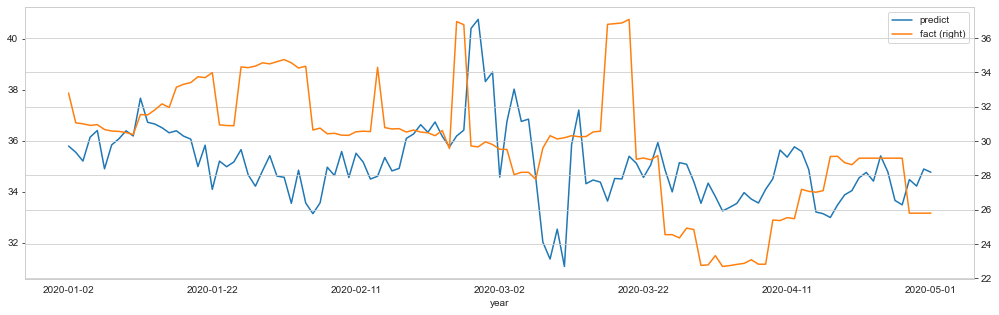

In [979]:
import matplotlib.pyplot as plt # Impot the relevant module

fig, ax = plt.subplots() # Create the figure and axes object

# Plot the first x and y axes:
df.plot(x = 'year', y = 'predict',title = "AKSH_211", ax = ax) 
# Plot the second x and y axes. By secondary_y = True a second y-axis is requested:
# (see https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.html for details)
df.plot(x = 'year', y = 'fact', ax = ax, secondary_y = True)

In [980]:
from sklearn.metrics import r2_score
r2_score(Y_traint, yhatt)


-2.300754845140294

In [982]:
def line_plot(line2, line1, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(16, 9))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    
    ax.set_ylabel('liqvol', fontsize=14)
    ax.set_title(title, fontsize=18)
    ax.legend(loc='best', fontsize=18);

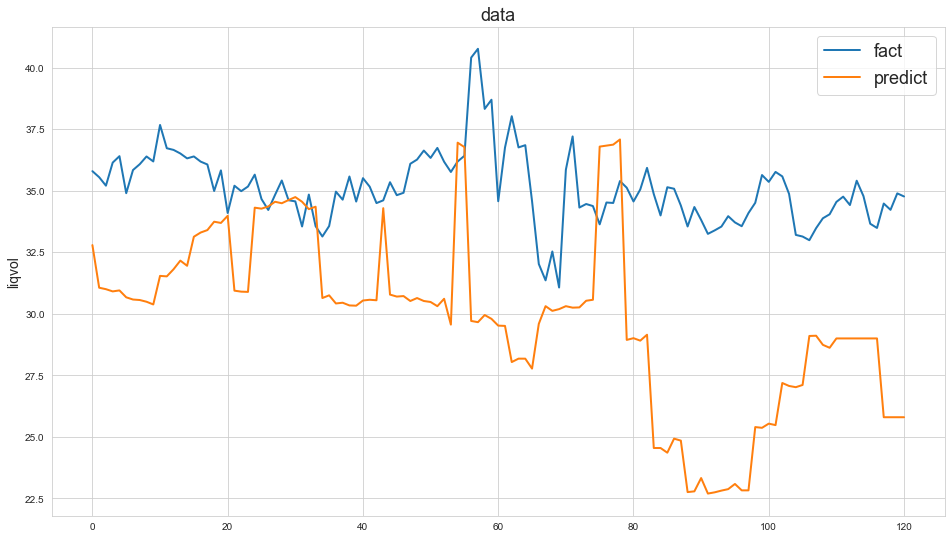

In [983]:
line_plot(Y_traint, yhatt,'fact','predict',  title='data')

In [984]:
from sklearn.metrics import mean_squared_error
mean_squared_error(Y_traint, yhatt)

40.38883386962975

In [693]:
print(mean_absolute_percentage_error(Y_traint, yhatt))

32.759677463481545
